# 1- Importation des librairies

In [1]:
import numpy,pandas
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from copy import copy
import math

# Chargement du dataset

In [2]:
data=pandas.read_csv("sleep_data.csv")
data

,Date,Slept,Got up,Duration,How quickly fell asleep,How easy got up,How felt afterwards
0,21.10.2017,23:30,05:00,5.50,4.5,4.5,4.0
1,21.10.2017,11:45,12:10,0.42,4.5,3.5,4.5
2,22.10.2017,23:00,05:00,6.00,3.5,3.0,3.0
3,22.10.2017,06:05,09:05,3.00,4.0,4.5,5.0
4,22.10.2017,14:25,15:50,1.42,3.5,2.5,4.5
...,...,...,...,...,...,...,...
161,29.01.2018,00:50,05:50,5.00,3.0,4.5,4.0
162,30.01.2018,00:15,05:25,5.17,4.0,4.5,5.0
163,30.01.2018,06:15,08:50,2.58,4.0,2.5,4.0
164,31.01.2018,00:05,05:28,5.38,5.0,5.0,4.5


## Dimensions du dataset

In [3]:
data.shape

(166, 7)

# 2- Analyses statistiques

## Nombre de jours d'observation

In [5]:
data['Date'].value_counts()

08.11.2017    3
23.12.2017    3
26.10.2017    3
09.12.2017    3
22.10.2017    3
             ..
10.11.2017    1
30.11.2017    1
01.01.2018    1
02.01.2018    1
11.12.2017    1
Name: Date, Length: 103, dtype: int64

In [6]:
distinct_dates_length=len(data['Date'].unique())
distinct_dates_length

103

## Statistiques sur la durée de sommeil

<AxesSubplot:>

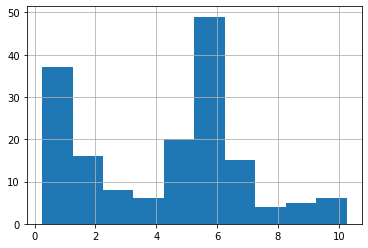

In [7]:
data['Duration'].hist()

In [8]:
data['Duration'].min()

0.25

In [9]:
data['Duration'].max()

10.25

In [10]:
data['Duration'].mean()

4.222228915662652

# 3- Modélisation de la journée

## A- Test des méthodes

### Récupération des heures pour la première observation

In [11]:
time1=data.loc[0,'Slept']
time1

'23:30'

In [12]:
time2=data.loc[0,'Got up']
time2

'05:00'

### Traduction en synthaxe datetime Python

In [13]:
t1 = datetime.strptime(time1, "%H:%M")
print('Start time:', t1.time())

Start time: 23:30:00


In [14]:
t2 = datetime.strptime(time2, "%H:%M")
print('End time:', t2.time())

End time: 05:00:00


### Comparaion des deux temps

In [15]:
t1 == t2

False

### Différences en secondes des deux temps

In [16]:
diff=t1-t2
diff

datetime.timedelta(seconds=66600)

In [17]:
diff.total_seconds()

66600.0

### Ajout de secondes au temps

15min = 900secondes 

In [18]:
_15min=timedelta(seconds=900)
_15min

datetime.timedelta(seconds=900)

In [45]:
debut = datetime.strptime('00:00', "%H:%M")
print('Début :', debut.time())

fin = debut + _15min
print('Fin :', fin.time())

Début : 00:00:00
Fin : 00:15:00


## B- Création et initialisation du tableau initial 

### Création

Start : 00:00:00


### Initialisation

In [48]:
#Le début d'une journée
start = datetime.strptime('00:00', "%H:%M")

#On fixe le pas de discrétisation ici
_min=1

#Le pas de discrétisation converti en sec
_sec=timedelta(seconds=_min*60)

#Creation de la variable journée
journee=[]

#La variable qui permettra les insertions de dates
currently = start

#Equivalent de currently en secondes
total_sec=0

while (total_sec < 86400):
    journee.append([currently, total_sec,0])
    currently += _sec
    
    total_sec += _sec.total_seconds()

In [49]:
len(journee)

1440

## C- Algorithme 

In [50]:
for i in range(data.shape[0]):
    time1=data.loc[i,'Slept']
    time2=data.loc[i,'Got up'] 
    
    #Recupérer les temps en secondes avec comme reférence 00:00
    t0 = datetime.strptime('00:00', "%H:%M")
    t1 = (datetime.strptime(time1, "%H:%M") - t0).total_seconds()
    t2 = (datetime.strptime(time2, "%H:%M") - t0).total_seconds()
    
    #Cas où par exemple il s'endort à 23:30 et se reveille à 00:05, on doit mettre t2 dans la journée suivante
    if(t2 < t1):
        t2+=86400
    
    #Parcours de notre discrétisation de journée
    for j in range(len(journee)):
        
        #Recupérer la minute en secondes avec comme reférence 00:00
        journee_sec = (journee[j][0] - t0).total_seconds()
        
        #Prendre les journee_sec dans l'intervalle compris en t1 et t2
        #Et penser également aux:
        #Cas où t2 est dans la journée suivante, on doit prendre en compte les journee_sec dans la journee qui suit
        if((journee_sec >= t1 and journee_sec <= t2) or (journee_sec + 86400 >= t1 and journee_sec + 86400 <= t2) ):
                journee[j][2] += 1


### Conversion du résultat en tableau numpy

In [51]:
data2=numpy.array(journee)

#On va garder les deux dernières colonnes et laisser le dataetime
data2=data2[:,1:]
data2

array([[0, 77],
       [60.0, 77],
       [120.0, 77],
       ...,
       [86220.0, 74],
       [86280.0, 74],
       [86340.0, 75]], dtype=object)

### Récupération des deux colonnes sous forme de listes

In [52]:
heure=data2[:,0].tolist()
occurences=data2[:,1].tolist()

### Plotting

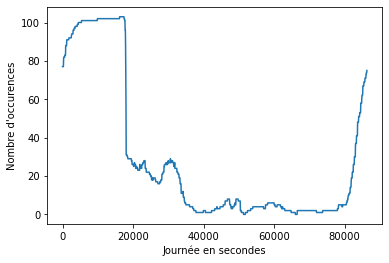

In [53]:
plt.plot(heure, occurences)
plt.xlabel('Journée en secondes')
plt.ylabel("Nombre d'occurences")

plt.show()

## C- Regression polynomiale 

### Modèle

In [29]:
modele = numpy.poly1d(numpy.polyfit(heure, occurences, 5))
print(modele)

           5             4             3             2
2.031e-21 x - 4.458e-16 x + 3.513e-11 x - 1.147e-06 x + 0.01117 x + 73.65


### Plotting

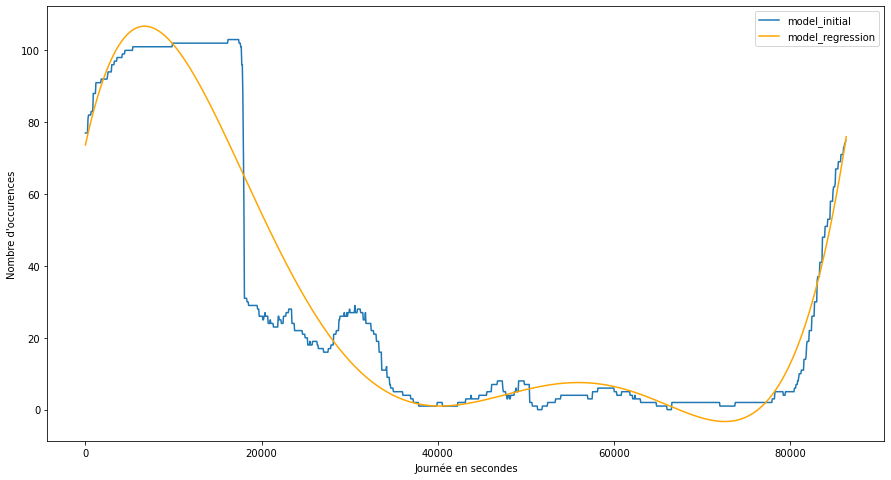

In [55]:
plt.figure(figsize=(15,8))
axe_x = numpy.linspace(1, 86400, 86400)
plt.plot(heure, occurences, label="model_initial")
plt.plot(axe_x, modele(axe_x), color="orange", label="model_regression")
plt.xlabel('Journée en secondes')
plt.ylabel("Nombre d'occurences")
plt.savefig('regression.png')
plt.legend() 
plt.show()

## D- Optimisation 

### Ecriture de la fonction objectif à base des valeurs du modèle

In [58]:
f1=lambda x: 2.031e-21*(x**5) - 4.458e-16*(x**4) + 3.513e-11*(x**3) - 1.147e-06*(x**2) + 0.01117*(x) + 73.65

In [59]:
f1(40000)

0.2964000000003182

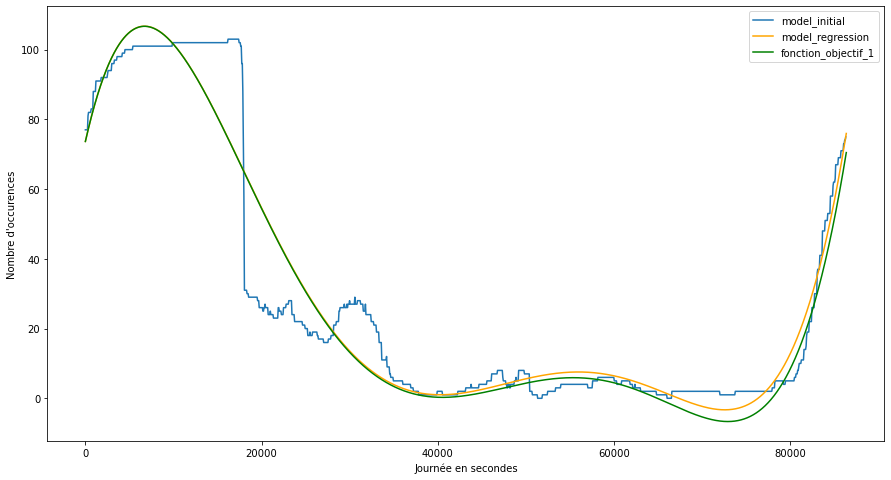

In [60]:
plt.figure(figsize=(15,8))
axe_x = numpy.linspace(1, 86400, 86400)
plt.plot(heure, occurences, label="model_initial")
plt.plot(axe_x, modele(axe_x), color="orange", label="model_regression")
plt.plot(axe_x, f1(axe_x), color="green", label="fonction_objectif_1")
plt.xlabel('Journée en secondes')
plt.ylabel("Nombre d'occurences")
plt.legend()
plt.show()

On a pris des valeurs approximatives pour créer notre fonction-objectif, si bien qu'elle ne colle pas entièrement avec le modele.

### Ecriture de la fonction objectif à base du modèle lui-mm

In [62]:
def f2(x, model_):
    resultat=0
    
    for i in range(len(model_)+1):
        x_i = model_[i]*(x**i)
        
        resultat += x_i
    
    return resultat

In [63]:
f2(40000,modele)

1.0193562579506477

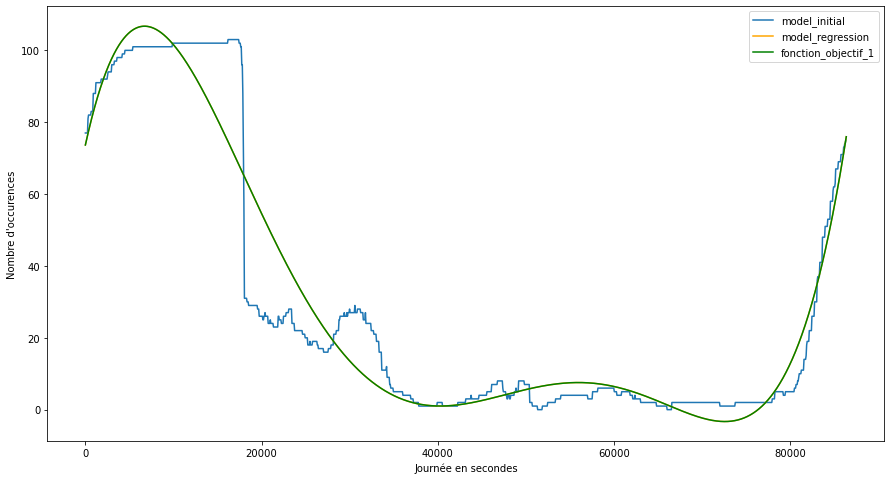

In [64]:
plt.figure(figsize=(15,8))
axe_x = numpy.linspace(1, 86400, 86400)
plt.plot(heure, occurences, label="model_initial")
plt.plot(axe_x, modele(axe_x), color="orange", label="model_regression")
plt.plot(axe_x, f2(axe_x,modele), color="green", label="fonction_objectif_1")
plt.xlabel('Journée en secondes')
plt.ylabel("Nombre d'occurences")
plt.legend()
plt.show()

### Optimisation avec SineCosineAlgorithm

In [65]:
import sys
sys.path.append("/SCA")
import SCA

In [79]:
solution=SCA.SCA(fonction_objectif=f2, model_=modele, lb=0, ub=86399, dim_individu=1, nombreIndividus=200, Max_iter=40)

SCA optimise  "f2"
["A l'iteration 0 la meilleure fitness est: -3.302706134613345"]
['Le meilleur associé est: [72543.56601448]']


["A l'iteration 1 la meilleure fitness est: -3.302706134613345"]
['Le meilleur associé est: [72543.56601448]']


["A l'iteration 2 la meilleure fitness est: -3.302917944301953"]
['Le meilleur associé est: [72645.75762299]']


["A l'iteration 3 la meilleure fitness est: -3.302917944301953"]
['Le meilleur associé est: [72645.75762299]']


["A l'iteration 4 la meilleure fitness est: -3.303285086040887"]
['Le meilleur associé est: [72597.48312118]']


["A l'iteration 5 la meilleure fitness est: -3.303285086040887"]
['Le meilleur associé est: [72597.48312118]']


["A l'iteration 6 la meilleure fitness est: -3.303285086040887"]
['Le meilleur associé est: [72597.48312118]']


["A l'iteration 7 la meilleure fitness est: -3.303285086040887"]
['Le meilleur associé est: [72597.48312118]']


["A l'iteration 8 la meilleure fitness est: -3.303285086040887"]
['Le meilleu

### Convertir secondes en heures

In [80]:
def convertion(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [81]:
texte="L'heure précise à laquelle cet individu est le plus susceptible d'etre en éveil est:"
print(texte+" "+convertion(solution[0][0]))

L'heure précise à laquelle cet individu est le plus susceptible d'etre en éveil est: 20:09:57
